# Dogs vs Cats

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

# to make this notebook's output stable across runs
np.random.seed(2210)


### Add the custom framework

In [24]:
WORK_DIR = '/kaggle/working'
INPUT_DIR = '/kaggle/input/dogs-vs-cats'
DATA_DIR = os.path.join(WORK_DIR, 'data')
CKPT_DIR = os.path.join(WORK_DIR, 'weights')

if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

if not os.path.isdir(CKPT_DIR):
    os.mkdir(CKPT_DIR)

import sys
sys.path.append('/kaggle/input/mlframework')
# sys.path.append('/home/jovyan/ml_framework')
# sys.path.append(os.path.join(os.path.expanduser('~'), 'github', 'ml_framework'))

from utils import file_utils, charts
_ = charts.set_rc(titlesize=10)

<Figure size 432x288 with 0 Axes>

In [ ]:
# ! ls /kaggle/input/dogs-vs-cats
! ls /kaggle/working

In [ ]:
# unzip the zip files
file_utils.unzip_file(os.path.join(INPUT_DIR,'train.zip'), os.path.join(WORK_DIR, 'data'))
file_utils.unzip_file(os.path.join(INPUT_DIR,'test1.zip'), os.path.join(WORK_DIR, 'data'))

### Load the csv file 

In [ ]:
TRAIN_DIR = os.path.join(DATA_DIR,'train')
TEST_DIR = os.path.join(DATA_DIR,'test1')
# Load the submission dataframe
submission_df = pd.read_csv(os.path.join(INPUT_DIR,'sampleSubmission.csv'))
submission_df.head()

In [ ]:
train_files = os.listdir(TRAIN_DIR)
test_files = os.listdir(TEST_DIR)

print(f"Total no. of training images : {len(train_files)}")
print(f"Total no. of test images : {len(test_files)}")

data = dict()
data['image'] = train_files
data['category'] = [ f'{x[0]}' for x in [x.split('.') for x in train_files] ]
# len(data['image']), len(data['category'])

df = pd.DataFrame(data)
df.head()

# Explore the data

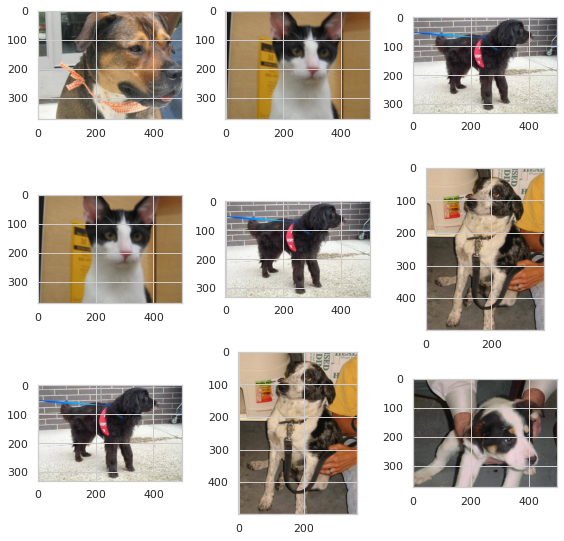

In [27]:
charts.plot_images([os.path.join(TRAIN_DIR, i) for i in random.sample(train_files, 9)], 3, 3)

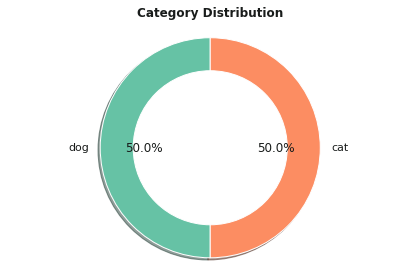

In [25]:
charts.donut(df['category'], title='Category Distribution', figsize=(6,4), titlesize=12)

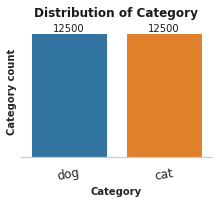

In [26]:
charts.value_count_bar(df['category'], normalize=False, figsize=(3.2, 3), titlesize=12, labelsize=10)

In [ ]:




from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.1, shuffle=True)

train_df.head()

### Build the model

In [ ]:
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from cnn.model_builder import get_vgg_block

In [ ]:
# def define_vgg_baseline(num_blocks=1, input_shape=(150, 150, 3),
#                         padding='same'):
#     assert 4 > num_blocks > 0, f'Number of blocks should be in range 1 and 3'
#     model = Sequential()
#     dropout_list = [.2, .2, .5]
#     filter_list = [32, 128, 128]

#     def dropout_value(index):
#         return dropout_list[index] if index <= len(dropout_list) else dropout_list[-1]

#     def filter_value(index):
#         return filter_list[index] if index <= len(filter_list) else filter_list[-1]
    
#     def get_conv(index):
#         conv = None
#         if index == 0:
#             return Conv2D(filters=filter_value(index), kernel_size=3,
#                              activation='relu', input_shape=input_shape,
#                              padding=padding)
#         else:
#             return Conv2D(filters=filter_value(index), kernel_size=3,activation='relu', padding=padding)
            

#     for i in range(num_blocks):
#         model.add(get_conv(i))
#         model.add(MaxPool2D(pool_size=2, strides=2))
#         model.add(Dropout(dropout_value(i)))
    
#     model.add(Flatten())

#     return model

# Build the model
model = get_vgg_block(num_blocks=3, input_shape=(150,150,3))
model.add(Dense(516, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(Adam(), loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_DIR,
    x_col="image",
    y_col="category",
    batch_size=64,
    class_mode="binary",
    target_size=(150, 150),
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=TRAIN_DIR,
    x_col="image",
    y_col="category",
    batch_size=64,
    class_mode="binary",
    target_size=(150, 150),
)

earlystopping = EarlyStopping(min_delta=0.001, monitor="val_loss", 
                              patience=4, restore_best_weights=True)

checkpoint= ModelCheckpoint(
    filepath=CKPT_DIR,
    save_weights_only=True,
    monitor="val_loss",
    mode="max",
    save_best_only=True,
)

In [17]:
# Train and fit model
history = model.fit(
    train_generator, validation_data=valid_generator,
    callbacks = [earlystopping, checkpoint],
    epochs=50, verbose=1
)

result_df = pd.DataFrame(history.history)
result_df.head()

Epoch 1/50
352/352 [==============================] - 82s 233ms/step - loss: 0.2608 - accuracy: 0.8907 - val_loss: 0.2928 - val_accuracy: 0.8800
Epoch 2/50
352/352 [==============================] - 82s 233ms/step - loss: 0.2547 - accuracy: 0.8946 - val_loss: 0.3179 - val_accuracy: 0.8696
Epoch 3/50
352/352 [==============================] - 81s 229ms/step - loss: 0.2443 - accuracy: 0.8997 - val_loss: 0.2929 - val_accuracy: 0.8840
Epoch 4/50
352/352 [==============================] - 81s 230ms/step - loss: 0.2439 - accuracy: 0.8996 - val_loss: 0.3128 - val_accuracy: 0.8696
Epoch 5/50
352/352 [==============================] - 81s 229ms/step - loss: 0.2285 - accuracy: 0.9057 - val_loss: 0.2925 - val_accuracy: 0.8808


,loss,accuracy,val_loss,val_accuracy
0,0.260777,0.890711,0.292850,0.8800
1,0.254721,0.894578,0.317937,0.8696
2,0.244277,0.899733,0.292902,0.8840
3,0.243908,0.899556,0.312797,0.8696
4,0.228550,0.905689,0.292494,0.8808


In [39]:
charts.plot_loss_acc(hist=history)

NameError: name 'history' is not defined

In [29]:
test_df = pd.DataFrame({'image': test_files})

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=TEST_DIR,
    x_col="image",
    y_col=None,
    batch_size=128,
    class_mode=None,
    target_size=(150, 150),
)

test_df.head()

Found 12500 validated image filenames.


,image
0,11340.jpg
1,8707.jpg
2,1937.jpg
3,6889.jpg
4,4062.jpg


In [31]:
predictions = model.predict(test_generator, steps=np.ceil(len(test_files)/128))
test_df['prediction'] = predictions
test_df['label'] = test_df['prediction'].apply(lambda x : 1 if x > 0.5 else 0)
test_df['id'] = test_df['image'].apply(lambda x : int(x.split('.')[0]))
test_df

,image,prediction,label,id
0,11340.jpg,0.980377,1,11340
1,8707.jpg,0.000014,0,8707
2,1937.jpg,0.011285,0,1937
3,6889.jpg,0.999206,1,6889
4,4062.jpg,0.999733,1,4062
...,...,...,...,...
12495,8339.jpg,0.014931,0,8339
12496,2752.jpg,0.126940,0,2752
12497,3503.jpg,0.988506,1,3503
12498,3417.jpg,0.999989,1,3417


In [32]:
test_df[test_df['id'].isin([18, 19, 1235, 4756])]

,image,prediction,label,id
877,18.jpg,0.074050,0,18
5044,4756.jpg,0.141565,0,4756
8595,1235.jpg,0.993326,1,1235
11310,19.jpg,0.063694,0,19


In [34]:
submission_df = test_df[['id','label']]
submission_df = submission_df.sort_values(by=['id'], ignore_index=True)
submission_df

,id,label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1
...,...,...
12495,12496,1
12496,12497,0
12497,12498,0
12498,12499,1


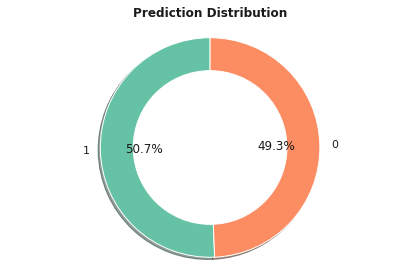

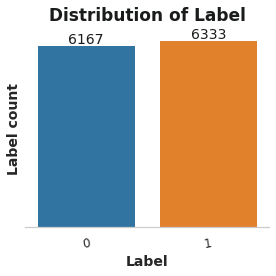

In [36]:
charts.donut(submission_df['label'], title='Prediction Distribution', figsize=(6,4), titlesize=12)
charts.value_count_bar(submission_df['label'], normalize=False, figsize=(4,4))

In [38]:
submission_df.to_csv('submission.csv', index=False)